# Customizing Colorbars

Plot legends identify discrete labels of discrete points. For continuous labels based on colors, a labeled colorbar can be a great tool. In Matplotlib, a colorbar is a separate axes that provides a key for the meaning of colors in a plot.

We'll start by setting up the notebook as usual:

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-notebook')
import numpy as np

As we have already seen, the simplest colorbar can be created with the `plt.colorbar` function:

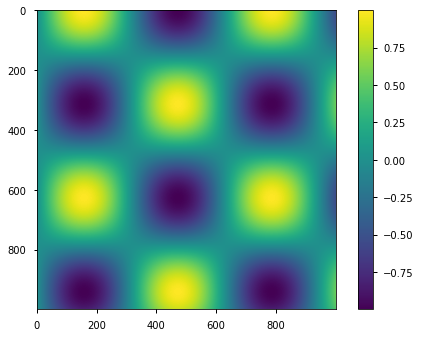

In [2]:
x = np.linspace(0, 10, 1000)
I = np.sin(x) * np.cos(x[:, np.newaxis])

plt.imshow(I)
plt.colorbar();

## Customizing Colorbars

The colormap can be specified using the `cmap` argument to the plotting function:

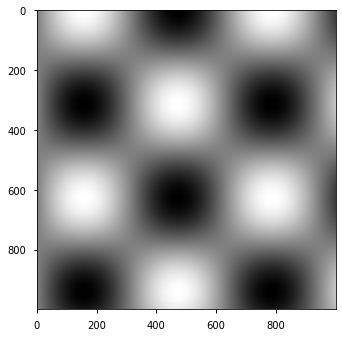

In [3]:
plt.imshow(I, cmap='gray');

All the available colormaps are in the `plt.cm` namespace, but it is important to know how to decide among all the possibilities.

### Choosing the Colormap

The book suggests [Ten Simple Rules for Better Figures](https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1003833) as a reference for some things to keep in mind while creating visualizations. Matplotlib's online documentation also has an [interesting discussion](https://matplotlib.org/3.3.3/tutorials/colors/colormap-manipulation.html) of colormap choice.

There are three different categories of colormaps to be aware of:
- _Sequential colormaps_: These are made up of one continuous sequence of colors (e.g. `binary` or `viridis`).
- _Divergent colormaps_: These usually contain two distinct colors, which are great to show positive and negative deviations from a mean (e.g. `RdBu` or `PuOr`).
- _Qualitative colormaps_: These mix colors with no particular sequence (e.g. `rainbow` or `jet`).

Among the problems of using a qualitative map such as `jet` to represent quantitative data, is the fact that qualitative maps usually do not display any uniform progression in brightness as the scale increases.

We can see this by converting the `jet` colorbar into black and white:

In [4]:
from matplotlib.colors import LinearSegmentedColormap

def grayscale_cmap(cmap):
    """Return a grayscale version of the given colormap"""
    cmap = plt.cm.get_cmap(cmap)
    colors = cmap(np.arange(cmap.N))
    
    # convert RGBA to perceived grayscale luminance
    # cf. http://alienryderflex.com/hsp.html
    RGB_weight = [0.299, 0.587, 0.114]
    luminance = np.sqrt(np.dot(colors[:, :3] ** 2, RGB_weight))
    colors[:, :3] = luminance[:, np.newaxis]
        
    return LinearSegmentedColormap.from_list(cmap.name + "_gray", colors, cmap.N)
    

def view_colormap(cmap):
    """Plot a colormap with its grayscale equivalent"""
    cmap = plt.cm.get_cmap(cmap)
    colors = cmap(np.arange(cmap.N))
    
    cmap = grayscale_cmap(cmap)
    grayscale = cmap(np.arange(cmap.N))
    
    fig, ax = plt.subplots(2, figsize=(6, 2),
                           subplot_kw=dict(xticks=[], yticks=[]))
    ax[0].imshow([colors], extent=[0, 10, 0, 1])
    ax[1].imshow([grayscale], extent=[0, 10, 0, 1])

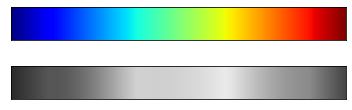

In [5]:
view_colormap('jet')

Notice the bright stripes in the grayscale image. Even in full color, this uneven brightness means that the eye will be drawn to certain portions of the color range, which will potentially emphasize unimportant parts of the dataset. It would be better to use a colormap such as `viridis`, which is specifically constructed to have an even brightness variation across the range:

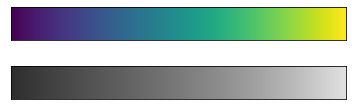

In [6]:
view_colormap('viridis')

For those that favor rainbow schemes, another good option for continuous data is the `cubehelix` colormap:

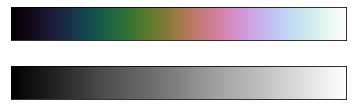

In [7]:
view_colormap('cubehelix')

For situations such as showing positive and negative deviations from some mean, dual-color colorbars such as `RdBu` (_Red-Blue_) can be useful. However, it's important to note that the positive-negative information will be lost upon translation to grayscale!

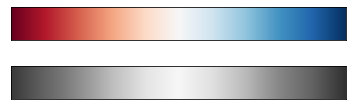

In [8]:
view_colormap('RdBu')

### Color limits and extensions

Matplotlib allows for a large range of colorbar customization. The colorbar itself is jsut an instance of `plt.Axes`, so all of the axes and tick formatting we've seen are applicable. The colorbar has a few interesting capabilities: for example, we can narrow the color limits and indicate the out-of-bound values with a triangular arrow at the top and bottom by setting the `extend` property. This might be useful when displaying an image that is subject to noise:

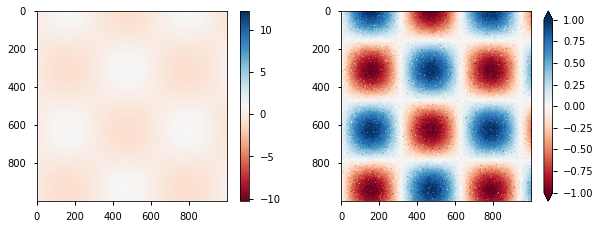

In [9]:
# make noise in 1% of the image pixels
speckles = (np.random.random(I.shape) < 0.01)
I[speckles] = np.random.normal(0, 3, np.count_nonzero(speckles))

plt.figure(figsize=(10, 3.5))

plt.subplot(1, 2, 1)
plt.imshow(I, cmap='RdBu')
plt.colorbar()

plt.subplot(1, 2, 2)
plt.imshow(I, cmap='RdBu')
plt.colorbar(extend='both')
plt.clim(-1, 1);

Notice that in the left panel, the default color limits respond to the noisy pixels, and the range of the noise completely washes-out the pattern we are interested in. In the right panel, the color limits are manually set, and we add  extensions to indicate values which are above or below those limits.

### Discrete Color Bars

Colormaps are continuous by default, but sometimes it is useful to represent discrete values. This can be easily achieved using the `plt.cm.get_cmap()` function, and pass the name of a suitable colormap along with the number of desired bins:

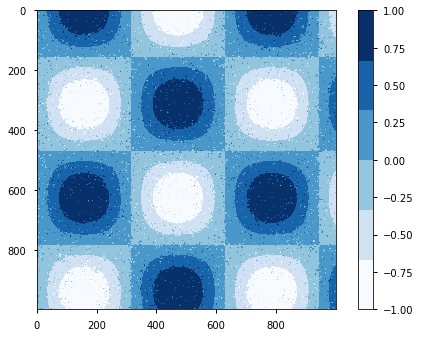

In [10]:
plt.imshow(I, cmap=plt.cm.get_cmap('Blues', 6))
plt.colorbar()
plt.clim(-1, 1);

The discrete version of a colormap can be used just like any other colormap.

## Example: Handwritten Digits

For an example of where this might be useful, let's look at an interesting visualization of some hand written digits data from the MNIST dataset.

We 'll start by downloading the digits data from Scikit-Learn and visualizing several of the example images with `plt.imshow()`:

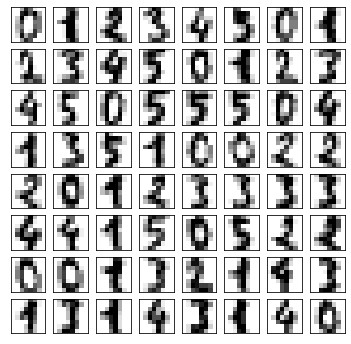

In [11]:
# load images of the digits 0 through 5 and visualize several of them
from sklearn.datasets import load_digits
digits = load_digits(n_class=6)

fig, ax = plt.subplots(8, 8, figsize=(6, 6))
for i, axi in enumerate(ax.flat):
    axi.imshow(digits.images[i], cmap='binary')
    axi.set(xticks=[], yticks=[])

Given that each digit is defined by the hue of its 64 pixels, we can consider each to be point lying in a 64-dimensional space where each dimension represents the brightness of one pixel. Visualizing relationships in such high-dimensional spaces can be a very challenging task. One way to approach this by using a _dimensionality reduction_ technique such as manifold learning to reduce the dimensionality of the data while maintaining the relationships of interest. 

Let's take a look at a two-dimensional manifold learning projection of this digits data:

In [12]:
# project the digits into 2 dimensions using IsoMap
from sklearn.manifold import Isomap
iso = Isomap(n_components=2)
projection = iso.fit_transform(digits.data)

We'll use a discrete colormap to view the results, setting the `ticks` and `clim` to improve the aesthetics of the resulting colorbar:

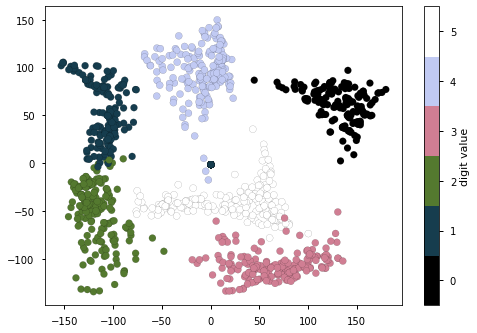

In [13]:
# plot the results
plt.scatter(projection[:, 0], projection[:, 1], lw=0.1, edgecolors='k',
            c=digits.target, cmap=plt.cm.get_cmap('cubehelix', 6))
plt.colorbar(ticks=range(6), label='digit value')
plt.clim(-0.5, 5.5)

This projection also gives us some interesting insights on the relationships within the dataset: for example, the ranges of 5 and 3 nearly overlap in this projection, indicating that some hand written fives and threes are difficult to distinguish, and therefore more likely to be confused by a classificator. Values such as 0 and 1 are more distantly separated, and therefore much less likely to be confused.